In [11]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy

## DLN Setup

In [12]:
class DeepMatrixFactorization(nn.Module):
    def __init__(self, d, depth, init_scale=1e-2):
        super(DeepMatrixFactorization, self).__init__()

        self.factors = nn.ParameterList([nn.Parameter(torch.randn(d, d) * 0)] + 
                                        [torch.nn.init.orthogonal_(torch.empty(d, d), gain=init_scale) for _ in range(depth-1)])

    def forward(self):
        product = self.factors[0]
        for i in range(1, len(self.factors)):
            product = product @ self.factors[i]
        return product

In [13]:
def train_gd(step_size,
              n_outer_loops,
              n_inner_loops,
              tol,
              model,
              target,
              callback=None):
    
    """
    Training function for deep matrix factorization.
    """
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=step_size, weight_decay=0.0)

    test_losses = []
    train_losses = []
    weights_list = []
        
    pbar = tqdm(range(n_outer_loops))

    for itr in pbar:
        for _ in range(n_inner_loops):
            # Update
            optimizer.zero_grad()
                
            train_loss = criterion(model(), target)

            train_loss.backward()
            optimizer.step()
    
        test_loss = criterion(model(), target)
        test_losses.append( test_loss.detach().numpy() )
        
        if train_loss < tol:
            break
                
        if callback:
            callback(itr=itr, model=model, target=target)
    
        pbar.set_description(f"Train loss: {train_loss:0.2e}, test loss: {test_loss:0.2e}")
        weights_list.append( deepcopy(model) )
    result_dict = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'weights': weights_list,
        'final_weights': deepcopy(model)
    }
    
    return result_dict

## Generating Data

In [14]:
def generate_data(shape, rank):
    mat = torch.randn(shape)
    
    if rank is not None:
        U, S, V = torch.svd( mat )
        
    return U[:, :rank] @ torch.diag(S[:rank]) @ V[:, :rank].T

In [15]:
d = 100
r = 3

target = generate_data(shape=(d,d), rank=r)

## Training

In [16]:
# Parameters
depth = 3
tol = 1e-8
n_outer_loops = 1000
n_inner_loops = 100
step_size = 1

init_scale = 0.01

model = DeepMatrixFactorization(d=d, depth=depth, init_scale=init_scale)

# Train model
gd_result = train_gd(
                step_size=step_size,
                n_outer_loops=n_outer_loops,
                n_inner_loops=n_inner_loops,
                tol=tol,
                model=model,
                target=target,
    #           callback=callback           
)

Train loss: 2.78e-07, test loss: 2.61e-07:  42%|████▏     | 422/1000 [00:37<00:52, 11.11it/s]


## Training All Orthogonal

In [17]:
class DeepMatrixFactorizationOrth(nn.Module):
    def __init__(self, d, depth, init_scale=1e-2):
        super(DeepMatrixFactorizationOrth, self).__init__()
        self.factors = nn.ParameterList([nn.Parameter(torch.nn.init.orthogonal_(torch.empty(d, d), gain=init_scale)) for _ in range(depth)])
        
    def forward(self):
        product = self.factors[0]
        for i in range(1, len(self.factors)):
            product = product @ self.factors[i]
        return product

In [18]:
orth_model = DeepMatrixFactorizationOrth(d=d, depth=depth, init_scale=init_scale)

# Train model
orth_gd_result = train_gd(
                step_size=step_size,
                n_outer_loops=n_outer_loops,
                n_inner_loops=n_inner_loops,
                tol=tol,
                model=orth_model,
                target=target,
    #           callback=callback           
)

Train loss: 1.11e-01, test loss: 1.11e-01:   0%|          | 0/1000 [00:00<?, ?it/s]

Train loss: 8.57e-07, test loss: 8.07e-07:  33%|███▎      | 334/1000 [00:31<01:02, 10.58it/s]


## Plotting

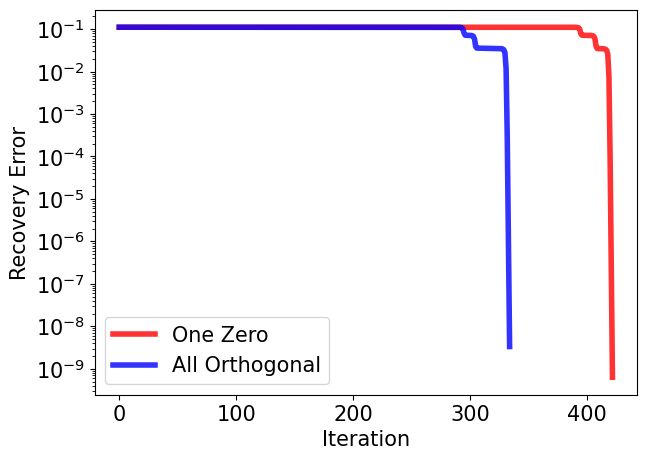

In [19]:
fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(111)

ax.semilogy(gd_result['test_loss'], c='red', linewidth=4, label=r'One Zero', alpha=0.8)
ax.semilogy(orth_gd_result['test_loss'], c='blue', linewidth=4, label=r'All Orthogonal', alpha=0.8)
#ax.semilogy(sigma_y, c='gray', linewidth=3, linestyle='--', label=r'$\sigma_{\mathbf{y}} = 0.01$', alpha=0.5)
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('Recovery Error', fontsize=15)
#ax.set_title(rf'd = {d}, k = {k}, T = {T}, $\ell$ = {ell}, p = {p}', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=15)